In [28]:
import cv2
import numpy as np
from pathlib import Path

In [29]:
# Path to video file
video_path = Path("data/videos/test_video_3.mp4")

# Initialize video capture
cap = cv2.VideoCapture(str(video_path))

if not cap.isOpened():
    raise ValueError(f"Cannot open video: {video_path}")

# Get video properties
n_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
fps = cap.get(cv2.CAP_PROP_FPS)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

print(f"Video: {n_frames} frames, {fps:.2f} FPS, {width}x{height}")

Video: 756 frames, 30.00 FPS, 848x464


In [30]:
# Feature tracking parameters for Lucas-Kanade optical flow
lk_params = dict(
    winSize=(15, 15),
    maxLevel=2,
    criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03)
)

# Good features to track parameters
feature_params = dict(
    maxCorners=200,
    qualityLevel=0.01,
    minDistance=30,
    blockSize=3
)

# Read first frame
ret, prev_frame = cap.read()
if not ret:
    raise ValueError("Cannot read first frame")

prev_gray = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)

# Pre-define transformation-store array (dx, dy, da)
transforms = np.zeros((n_frames - 1, 3), np.float32)

print("Starting feature tracking with Lucas-Kanade optical flow...")

Starting feature tracking with Lucas-Kanade optical flow...


In [31]:
# Compute optical flow and extract transforms
for i in range(n_frames - 2):
    # Detect feature points in previous frame
    prev_pts = cv2.goodFeaturesToTrack(prev_gray, **feature_params)
    
    if prev_pts is None:
        print(f"Frame {i}: No features detected, skipping")
        continue
    
    # Read next frame
    ret, curr_frame = cap.read()
    if not ret:
        break
    
    # Convert to grayscale
    curr_gray = cv2.cvtColor(curr_frame, cv2.COLOR_BGR2GRAY)
    
    # Calculate optical flow (track feature points) using Lucas-Kanade
    curr_pts, status, err = cv2.calcOpticalFlowPyrLK(
        prev_gray, curr_gray, prev_pts, None, **lk_params
    )
    
    # Filter only valid points
    idx = np.where(status == 1)[0]
    prev_pts_valid = prev_pts[idx]
    curr_pts_valid = curr_pts[idx]
    
    if len(prev_pts_valid) < 4:
        print(f"Frame {i}: Not enough valid points ({len(prev_pts_valid)}), skipping")
        prev_gray = curr_gray
        continue
    
    # Find transformation matrix (OpenCV 4 compatible)
    m, inliers = cv2.estimateAffinePartial2D(prev_pts_valid, curr_pts_valid)
    
    if m is not None:
        # Extract translation
        dx = m[0, 2]
        dy = m[1, 2]
        
        # Extract rotation angle
        da = np.arctan2(m[1, 0], m[0, 0])
        
        # Store transformation
        transforms[i] = [dx, dy, da]
    
    # Move to next frame
    prev_gray = curr_gray
    
    if (i + 1) % 50 == 0:
        print(f"Frame: {i + 1}/{n_frames} - Tracked points: {len(prev_pts_valid)}")

print(f"\nFeature tracking complete. Processed {i + 1} frames.")

Frame: 50/756 - Tracked points: 200
Frame: 100/756 - Tracked points: 147
Frame: 150/756 - Tracked points: 158
Frame: 200/756 - Tracked points: 195
Frame: 250/756 - Tracked points: 199
Frame: 300/756 - Tracked points: 200
Frame: 350/756 - Tracked points: 200
Frame: 400/756 - Tracked points: 199
Frame: 450/756 - Tracked points: 198
Frame: 500/756 - Tracked points: 200
Frame: 550/756 - Tracked points: 188
Frame: 600/756 - Tracked points: 197
Frame: 650/756 - Tracked points: 198
Frame: 700/756 - Tracked points: 198
Frame: 750/756 - Tracked points: 200

Feature tracking complete. Processed 754 frames.


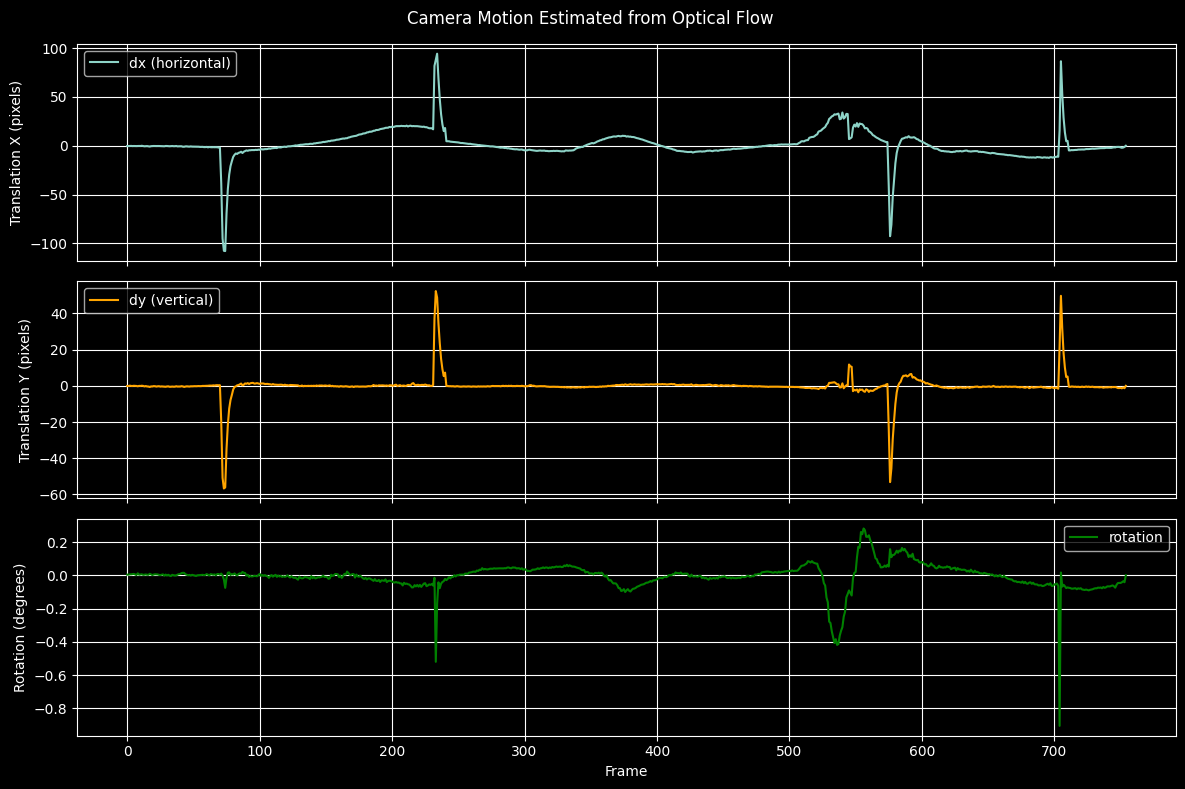

Max translation: dx=94.37, dy=52.33
Max rotation: 0.28 degrees


In [32]:
import matplotlib.pyplot as plt

# Visualize the computed transforms
fig, axes = plt.subplots(3, 1, figsize=(12, 8), sharex=True)

axes[0].plot(transforms[:, 0], label='dx (horizontal)')
axes[0].set_ylabel('Translation X (pixels)')
axes[0].legend()
axes[0].grid(True)

axes[1].plot(transforms[:, 1], label='dy (vertical)', color='orange')
axes[1].set_ylabel('Translation Y (pixels)')
axes[1].legend()
axes[1].grid(True)

axes[2].plot(np.degrees(transforms[:, 2]), label='rotation', color='green')
axes[2].set_ylabel('Rotation (degrees)')
axes[2].set_xlabel('Frame')
axes[2].legend()
axes[2].grid(True)

plt.suptitle('Camera Motion Estimated from Optical Flow')
plt.tight_layout()
plt.show()

print(f"Max translation: dx={transforms[:, 0].max():.2f}, dy={transforms[:, 1].max():.2f}")
print(f"Max rotation: {np.degrees(transforms[:, 2].max()):.2f} degrees")

Processed 100/756 frames
Processed 200/756 frames
Processed 300/756 frames
Processed 400/756 frames
Processed 500/756 frames
Processed 600/756 frames
Processed 700/756 frames


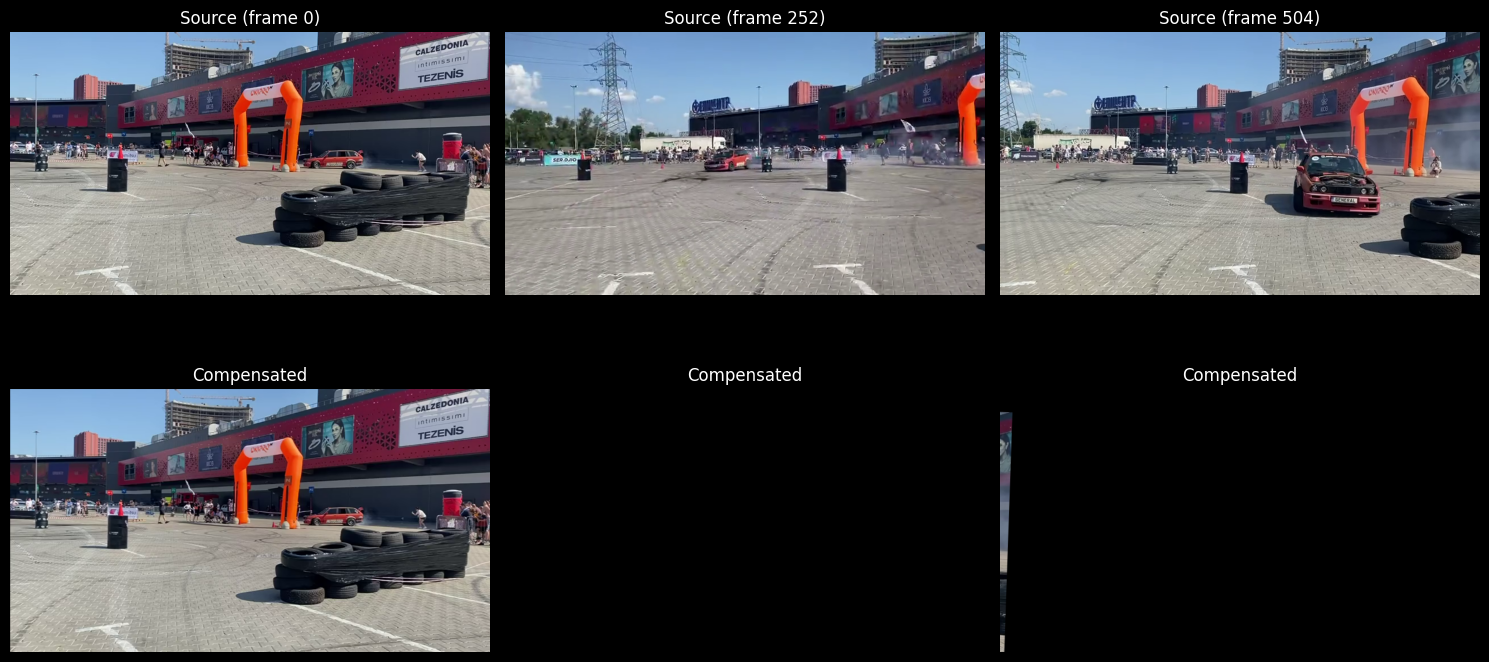


Processed and saved 756 frames
Source frames: C:\Motion-detection\data\source_frames
Compensated frames: C:\Motion-detection\data\compensated_frames


In [33]:
# Reset video capture for motion compensation
cap = cv2.VideoCapture(str(video_path))

# Create output directories
output_dir = Path("data")
source_dir = output_dir / "source_frames"
compensated_dir = output_dir / "compensated_frames"
source_dir.mkdir(parents=True, exist_ok=True)
compensated_dir.mkdir(parents=True, exist_ok=True)

# Compute cumulative transforms for stabilization
trajectory = np.cumsum(transforms, axis=0)

# Process all frames
frame_count = 0
sample_frames = []
sample_interval = n_frames // 3  # collect 3 samples for display

while True:
    ret, frame = cap.read()
    if not ret:
        break
    
    if frame_count < len(trajectory):
        # Get cumulative transform at this frame
        dx, dy, da = trajectory[frame_count]
        
        # Build inverse transformation matrix to compensate for motion
        cos_a = np.cos(-da)
        sin_a = np.sin(-da)
        
        # Create affine transformation matrix (inverse of camera motion)
        m_compensate = np.array([
            [cos_a, -sin_a, -dx],
            [sin_a, cos_a, -dy]
        ], dtype=np.float32)
        
        # Apply motion compensation
        compensated_frame = cv2.warpAffine(frame, m_compensate, (width, height))
    else:
        compensated_frame = frame
    
    # Save both frames
    cv2.imwrite(str(source_dir / f"frame_{frame_count:04d}.png"), frame)
    cv2.imwrite(str(compensated_dir / f"frame_{frame_count:04d}.png"), compensated_frame)
    
    # Collect samples for display
    if frame_count % sample_interval == 0 and len(sample_frames) < 3:
        sample_frames.append((frame_count, frame.copy(), compensated_frame.copy()))
    
    frame_count += 1
    
    if frame_count % 100 == 0:
        print(f"Processed {frame_count}/{n_frames} frames")

cap.release()

# Display sample comparisons
if sample_frames:
    fig, axes = plt.subplots(2, len(sample_frames), figsize=(15, 8))
    for idx, (fnum, src, comp) in enumerate(sample_frames):
        axes[0, idx].imshow(cv2.cvtColor(src, cv2.COLOR_BGR2RGB))
        axes[0, idx].set_title(f"Source (frame {fnum})")
        axes[0, idx].axis('off')
        
        axes[1, idx].imshow(cv2.cvtColor(comp, cv2.COLOR_BGR2RGB))
        axes[1, idx].set_title("Compensated")
        axes[1, idx].axis('off')
    
    plt.tight_layout()
    plt.show()

print(f"\nProcessed and saved {frame_count} frames")
print(f"Source frames: {source_dir.absolute()}")
print(f"Compensated frames: {compensated_dir.absolute()}")